# Tutorial: Creating Gym Environments

This notebook will help you an introduction on how to create RL environments using the [Gymnasium](https://gymnasium.farama.org/) library. 

Please take a look at the documentation of the library before starting.

In [ ]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 11.3 MB/s eta 0:00:00


In [ ]:
import time
import IPython
import numpy as np
import gymnasium as gym

from PIL import Image

## Environment Definition

To illustrate the process of creating a gym environement using the gymnasium library, we will implement a simplistic GridWorld. The environment consists of a 2-dimensional square grid of fixed size (specified via the size parameter during construction). The agent can move vertically or horizontally between grid cells in each timestep. The goal of the agent is to navigate to a target on the grid that has been placed randomly at the beginning of the episode. There is catch however, some cells are DANGEROUS, this means that when a player takes an action within be in one of the dangerous cells there is a $\alpha$ probability of succeding the desired action and a probability $1-\alpha$ to take another random action instead (slipped).

Observations provide the location of the target the agent and the locations of the dangerous cells.

There are 4 actions in our environment, corresponding to the movements “right”, “up”, “left”, and “down”.

A done signal is produced as soon as the agent has navigated to the grid cell where the target is located.

Rewards are binary and sparse, meaning that the immediate reward is always zero, unless the agent has reached the target, then it is 1.

An episode in this environment (with size=5) might look like this when rendered in ansi mode:

```
+-----+
|...A.|
|D....|
|....D|
|..TD.|
|.....|
+-----+
```
where the `A` is the agent and the `T` square represents the target and the `D` squares the perils.

Let us look at the source code of DangerousWorld piece by piece:

In [ ]:
class DangerousWorld(gym.Env):
  # These metadata are required from the gym and are related to rendering
  """
  The DangerousWorld environment consists of a 2-dimensional square grid of 
  fixed size (specified via the size parameter during construction). The agent 
  can move vertically or horizontally between grid cells in each timestep. The 
  goal of the agent is to navigate to a target on the grid that has been placed 
  randomly at the beginning of the episode. There is catch howver, some cells 
  are dangerous, this means that when a player takes an action within be in one 
  of the dangerous cells there is a $alpha$ probability of succeding the desired 
  action and a probability  $1−alpha$  to take another random action instead.
  """
  metadata = {"render_modes": ["ansi", "rgb"], "render_fps": 4}

  def __init__(self, size, alpha=0.5, n_dangers=3, render_mode="ansi"):
    """
      Constructor for the DangerousWorld
      Parameters:
              size (int): size of the gridworld
              alpha (float): probability of kept alive on dangerous cells
              n_dangers (int): number of dangerous cells
    """

    # Checks if the number of dangerous cells are fitting in the grid
    assert n_dangers < size**2+1, f"n_dangers should be at most {size**2}"

    self.render_mode = render_mode
    self.size = size
    self.alpha = alpha
    self.n_dangers = n_dangers

    # Create the self.action_space and an self.observation_space for the grid 
    # world using the spaces functionality of gymnasium (https://gymnasium.farama.org/api/spaces/)
    # for the observation space you can use a dictionary structure that holds 
    # the locations of the agent, target and dangerous locations. You can use the 
    # spaces.Box, spaces.Discrete and spaces.Dict.
    
    ### START CODE HERE ###
    self.observation_space = gym.spaces.Dict(
        {
            "agent": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "target": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "is_dangerous": gym.spaces.Tuple([gym.spaces.Box(0, size - 1, shape=(2,), dtype=int) for _ in range(n_dangers)])
        }
    )
    # We have 4 actions, corresponding to "right", "up", "left", "down"
    self.action_space = gym.spaces.Discrete(4)
    ### END CODE HERE ###

    """
    The following dictionary maps abstract actions from `self.action_space` to
    the direction we will walk in if that action is taken.
    I.e. 0 corresponds to "right", 1 to "up" etc.
    """
    self._action_to_direction = {
        0: np.array([1, 0]),
        1: np.array([0, 1]),
        2: np.array([-1, 0]),
        3: np.array([0, -1]),
    }

  def reset(self, seed=None, options=None):
    # We need the following line to seed self.np_random
    super().reset(seed=seed)

    # Sample unique n_dangerous (+2 for agent and target) locations using the 
    # function self.np_random.integers() function in order to populate the 
    # locations for all the elements of the gridworld and store them at
    # self._agent_location, self._target_location and self._is_dangerous 
    # variables.

    ### START CODE HERE ###
    locations = []
    while len(locations) < 2 + self.n_dangers:
      loc = list(self.np_random.integers(0, self.size, size=2, dtype=int))
      if not loc in locations:
        locations.append(loc)

    self._agent_location = np.array(locations[0])
    self._target_location = np.array(locations[1])
    self._is_dangerous = tuple([np.array(l) for l in locations[2:]])
    ### END CODE HERE ###

    self.last_action = None
    self.dead = False

    # initialize level paramters related to the rgb render
    if self.render_mode=='rgb':
      self._init_rgb_render()

    # returns observations and info.
    observation = self._get_obs()
    info = self._get_info()

    return observation, info

  # Implement the two private functions [_get_obs() and _get_info()] which 
  # return the current observation and a dictionary with info (e.g. the 
  # distance between) the target and location. Be careful, the observation
  # should follow the structure of the observation space.

  ### START CODE HERE ###
  def _get_obs(self):
    return {
        "agent": self._agent_location, 
        "target": self._target_location,
        "is_dangerous": self._is_dangerous
    }

  def _get_info(self):
    return {
        "distance": np.linalg.norm(
            self._agent_location - self._target_location, ord=1
        )
    }
  ### END CODE HERE ###

  def step(self, action):
    self.dead = False
    self.last_action = action
    # Check if standing on dangerous cell. If so, perform the selected action
    # with probability self.alpha otherwise terminate and set the reward 
    # accordingly.
    ### START CODE HERE ###
    if list(self._agent_location) in [list(i) for i in self._is_dangerous]:
      if self.np_random.random() < self.alpha:
        a = self.action_space.sample()
      else:
        self.dead = True
    ### END CODE HERE ###

    # Agent falls dead and therefore cannot move
    if not self.dead:
      # Map the action (element of {0,1,2,3}) to the direction we walk in using
      # the self._action_to_direction
      direction = self._action_to_direction[action]
      # We use `np.clip` to make sure we don't leave the grid
      self._agent_location = np.clip(
          self._agent_location + direction, 0, self.size - 1
      )
    
    # Populate all the variables that are returned from the function
    ### START CODE HERE ###
    observation = self._get_obs()
    terminated = np.array_equal(self._agent_location, self._target_location) or self.dead
    reward = -100 if self.dead else -1  # Binary sparse rewards
    info = self._get_info()
    ### END CODE HERE ###

    return observation, reward, terminated, False, info

  def render(self):
    if self.render_mode=='ansi':
      return self._render_text()
    if self.render_mode=='rgb':
      return self._render_rgb()


  def _render_text(self):
    r = np.empty((self.size,self.size), dtype=str)
    r[:] = '.'
    for i in range(len(self._is_dangerous)):
      r[self._is_dangerous[i][0],self._is_dangerous[i][1]] = 'D'
    r[self._target_location[0],self._target_location[1]] = 'T'
    # if agent over dangerous tile change character
    if list(self._agent_location) in [list(i) for i in self._is_dangerous]:
      r[self._agent_location[0],self._agent_location[1]] = 'Ã'
    else:
      r[self._agent_location[0],self._agent_location[1]] = 'A'
    self._render = r

    # Render borders for aesthetic reasons
    rr = np.pad(r, ((1,1),(0,0)), 'constant', constant_values=('-')) 
    rrr = np.pad(rr, ((0,0),(1,1)), 'constant', constant_values=('|'))
    rrr[0,0] = "+"
    rrr[0,-1] = "+"
    rrr[-1,0] = "+"
    rrr[-1,-1] = "+"
    r_str = "\n".join(["".join(i) for i in rrr])
    if self.last_action is not None:
      r_str += f"\n({['Down', 'Right', 'Up', 'Left'][self.last_action]})\n"

    if self.dead:
      r_str += "Dead!"
    return r_str

  def _render_rgb(self):
    r_rgb = Image.fromarray(self.lvl_img).convert("RGBA")
    
    tloc = self._target_location+np.array([2,1])
    target_rgb_np = np.zeros((r_rgb.size[0],r_rgb.size[1],4), dtype='uint8')
    target_rgb_np[
        tloc[0]*16:tloc[0]*16+16,
        tloc[1]*16:tloc[1]*16+16,
        :
    ] = self.lvl_target
    target_rgb = Image.fromarray(target_rgb_np).convert("RGBA")
    r_rgb.alpha_composite(target_rgb)


    for i in range(self.n_dangers):
      # adding [2,1] to account for borders
      sloc = self._is_dangerous[i]+np.array([2,1])
      danger_rgb_np = np.zeros((r_rgb.size[0],r_rgb.size[1],4), dtype='uint8')
      danger_rgb_np[
        sloc[0]*16:sloc[0]*16+16,
        sloc[1]*16:sloc[1]*16+16,
        :
      ] = self.lvl_obstacles[i]
      danger_rgb = Image.fromarray(danger_rgb_np).convert("RGBA")
      r_rgb.alpha_composite(danger_rgb)

    aloc = self._agent_location+np.array([2,1]) 
    agent_rgb_np = np.zeros((r_rgb.size[0],r_rgb.size[1],4), dtype='uint8')
    agent_rgb_np[
        aloc[0]*16:aloc[0]*16+16,
        aloc[1]*16:aloc[1]*16+16,
        :
    ] = self.lvl_agent
    agent_rgb = Image.fromarray(agent_rgb_np).convert("RGBA")
    r_rgb.alpha_composite(agent_rgb)
    return r_rgb.resize((300,300),Image.NEAREST)

  def _init_rgb_render(self):
    import requests
    from io import BytesIO
    response = requests.get("https://gist.githubusercontent.com/stergioc/28daf8770b4f1bf1622bd1355c8f88d0/raw/cd6903dbfc3b65829bc7eca056b1ed9e4eedf7be/GridWorld_tileset.png")
    tileset = Image.open(BytesIO(response.content)).convert('RGBA')
    tileset_np = np.array(tileset)
    tiles_16 = []
    for i in np.arange(0,tileset_np.shape[0], 16):
      for j in np.arange(0,tileset_np.shape[1], 16):
        tiles_16.append(tileset_np[i:i+16,j:j+16,:])
    self.tiles = {
        0 : tiles_16[22:27],  # floor
        1 : tiles_16[1:5],    # top
        2 : tiles_16[29:34],  # bottom
        3 : [tiles_16[7]]+[tiles_16[14]]+[tiles_16[21]], # left
        4 : [tiles_16[13]]+[tiles_16[20]]+[tiles_16[27]],# right
        5 : [tiles_16[34]],   # bottom right
        6 : [tiles_16[6]],    # top right
        7 : [tiles_16[28]],   # bottom left
        8 : [tiles_16[0]],    # top left
        9 : tiles_16[8:11],   # danger
        10: tiles_16[11:13] + tiles_16[15:20],  # players
        11: tiles_16[35:42],  # walls
        12: tiles_16[42:49],  # targets
    }

    self.lvl_lut = np.zeros((self.size,self.size))
    self.lvl_lut = np.pad(self.lvl_lut, ((1,0),(0,0)), 'constant', constant_values=(11)) 
    self.lvl_lut = np.pad(self.lvl_lut, ((1,0),(0,0)), 'constant', constant_values=(1)) 
    self.lvl_lut = np.pad(self.lvl_lut, ((0,1),(0,0)), 'constant', constant_values=(2))
    self.lvl_lut = np.pad(self.lvl_lut, ((0,0),(1,0)), 'constant', constant_values=(3))
    self.lvl_lut = np.pad(self.lvl_lut, ((0,0),(0,1)), 'constant', constant_values=(4))
    self.lvl_lut[0,0] = 8
    self.lvl_lut[0,-1] = 6
    self.lvl_lut[-1,0] = 7
    self.lvl_lut[-1,-1] = 5
    self.lvl_img = np.zeros(
        (self.lvl_lut.shape[0]*16,self.lvl_lut.shape[1]*16,4), 
        dtype='uint8'
    )
    for i in range(self.lvl_lut.shape[0]):
      for j in range(self.lvl_lut.shape[1]):
        idx = self.lvl_lut[i,j]
        tt = self.tiles[idx]
        self.lvl_img[i*16:i*16+16, j*16:j*16+16, :] = self.np_random.choice(tt)
    self.lvl_agent = self.np_random.choice(self.tiles[10])
    self.lvl_target = self.np_random.choice(self.tiles[12])
    self.lvl_obstacles = self.np_random.choice(
        self.tiles[9], 
        size=self.n_dangers
    )

## Initializing and Using the Environment

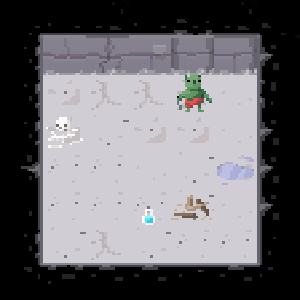

In [ ]:
# Initializes the environment and resets it.
env = DangerousWorld(size=5, alpha=0, n_dangers=3, render_mode='rgb')
env.reset(seed=42)
env.render()

In [ ]:
env = DangerousWorld(size=5, alpha=0.5, n_dangers=3, render_mode='ansi')
env.reset(seed=42)

out = display(IPython.display.Pretty(''), display_id=True)
# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, truncated, info = env.step(action)

    # Render the game
    out.update(IPython.display.Pretty(env.render()))
    time.sleep(0.5) # FPS

    # If player is dead break
    if done:
        break

env.close()
